In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def Thomas_Algorithm(a, b, c, d):

    ne = len(d) # number of equations
    ac, bc, cc, dc = map(np.array, (a, b, c, d)) # copy arrays
    for it in range(1, ne):   
        ac[it] = a[it] - b[it]*(c[it-1]/ac[it-1]) 
        dc[it] = d[it] - b[it]*(dc[it-1]/ac[it-1])

    xc = np.zeros(ne)
    xc[-1] = dc[-1]/ac[-1]
    for il in range(ne-2, -1, -1):
        xc[il] = (dc[il]/ac[il]) - (c[il]/ac[il])*xc[il+1]

    return xc 

In [3]:
def one_star_CNFDM (x0, rf, q, sigma, B, T, M, N, cr, K, early_redemption):

    #간격 값으로 나눠줌 (발생 가능한 가격)
    xh = np.arange(M+1) #세로축 간격 파싱
    dx = 0.01
    x = xh * dx

    dt = T/N
    pp = N/len(K)
    
    xmax = x0 * (1 + T * 3 * sigma)
    xmin = 0

    x0tag = np.where(x==x0)[0][0]
    Btag = np.where(x==B)[0][0]
    Rtag = 2 * pp * early_redemption

    '''u와 w경우 나누어 생각'''
    u = np.r_[np.where( x > B, 1 + cr[-1], x).reshape(1, M+1), np.zeros( (N, M+1) )]
    w = np.r_[np.where( x >= K[-1], 1 + cr[-1], x).reshape(1, M+1), np.zeros( (N, M+1) )]

    '''Boundary Condition'''
    u[:,0] = 2*u[:,1] - u[:,2]
    u[:,M] = 2*u[:,M-1] - u[:,M-2]
    w[:,0] = 2*w[:,1] - w[:,2]
    w[:,M] = 2*w[:,M-1] - w[:,M-2]

    '''CNFDM Coefficient'''
    a = ((dt/2)*(r + (sigma**2)*(xh**2))) #dt 시간텀 xh 가격 텀
    b = (dt/4)*((r-q)*xh - (sigma**2)*(xh**2))
    c = -(dt/4)*((r-q)*xh + (sigma**2)*(xh**2))

    '''universal condition'''
    a[1] = a[1] + 2*b[1]
    c[1] = c[1] - b[1]
    a[M-1] = a[M-1] + 2*c[M-1]
    b[M-1] = b[M-1] - c[M-1]

    a = a[1:M]
    b = b[1:M]
    c = c[1:M]

    '''for making d'''

    d = np.zeros(M-1)

    for n in range(0, N):
        
        '''Early Redemption Check '''
        for j in range(len(K)-1):
            if n == Rtag[j]:
                dummy = int(x0tag*K[len(K)-2-j])
                u[n,dummy:] = 1 + cr[len(K)-2-j]
                w[n,dummy:] = 1 + cr[len(K)-2-j]
        

        '''General Steps''' 
        d[0:M-1] = - b * u[n,:M-1] + (1 - a) * u[n,1:M] - c * u[n, 2:M+1]   
        d[0] = (1 - a[0]) * u[n,1] - c[0] * u[n,2]
        d[M-2] = (1-a[M-2]) * u[n, M-1] - b[M-2] * u[n,M-2]
        u[n+1, 1:M] = Thomas_Algorithm(1+a, b, c, d)

        d[0:M-1] = - b * w[n,:M-1] + (1 - a) * w[n,1:M] - c * w[n, 2:M+1]   
        d[0] = (1 - a[0]) * w[n,1] - c[0] * w[n,2]
        d[M-2] = (1-a[M-2]) * w[n, M-1] - b[M-2] * w[n,M-2]
        w[n+1, 1:M] = Thomas_Algorithm(1+a, b, c, d)

        '''Barrier Check'''
        u[n+1,1:Btag]= w[n+1,1:Btag]
        
        u[n+1,0] = 2*u[n+1,1] - u[n+1,2]
        u[n+1,M] = 2*u[n+1,M-1] - u[n+1,M-2]
        w[n+1,0] = 2*w[n+1,1] - w[n+1,2]
        w[n+1,M] = 2*w[n+1,M-1] - w[n+1,M-2]

    return u, x0tag, xmax




One-Star ELS CNFDM Price :  0.971728


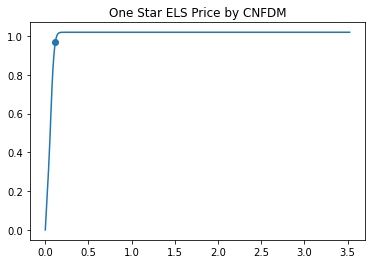

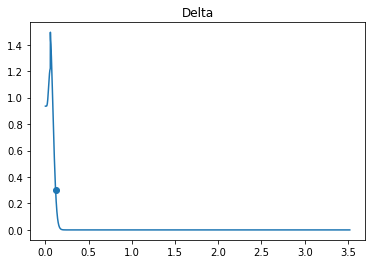

delta =  0.30435115517732925


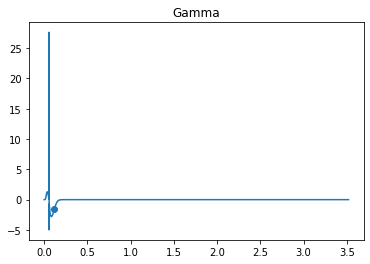

gamma =  -1.6198201783967914


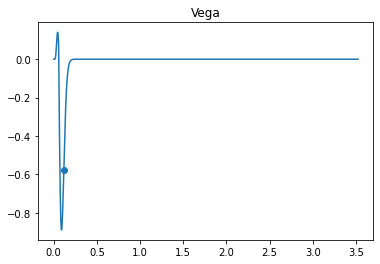

vega =  -0.5747541162212709


In [4]:
M = 3000
N = 600
sigma = 0.2803 #상품설명서에 고지된 KOSPI200 지수의 변동성
q = 0.0223 #한국거래소 180일 배당수익률 
r = 0.03 #22/9월 20일  91 CD 금리
#r= 
x0 = 1 #계산의 편의를 위해 KOSPI200의 현재 가격을 1로 가정
T = 3 #3년 만기물
coupon_rate = np.array([0.035, 0.07, 0.105, 0.14, 0.175, 0.21])
strike_price = np.array([0.95, 0.90, 0.85, 0.80, 0.75, 0.75])
early_redemption = np.array([0.5, 1, 1.5, 2, 2.5, 3])
B = 0.5


ELS_price, x0tag, xmax = one_star_CNFDM(x0, r, q, sigma, B, T, M, N, coupon_rate, strike_price, early_redemption)

print('One-Star ELS CNFDM Price : ', "%.6f" %ELS_price[N,x0tag])

#plotting
s = np.linspace(0, xmax,M+1)
plt.title('One Star ELS Price by CNFDM')
plt.plot(s,ELS_price[N,:])
plt.scatter(s[x0tag],ELS_price[N,x0tag])
plt.show()

delta = (ELS_price[N,1:] - ELS_price[N,:-1])/0.01
plt.title('Delta')
plt.plot(s[:-1], delta)
plt.scatter(s[x0tag], delta[x0tag])
plt.show()
print('delta = ', delta[x0tag])

gamma = (ELS_price[N,2:] - 2*ELS_price[N,1:-1] + ELS_price[N,:-2])/(0.01**2)
plt.title('Gamma')
plt.plot(s[:-2], gamma)
plt.scatter(s[x0tag], gamma[x0tag])
plt.show()
print('gamma = ', gamma[x0tag])

dsig = sigma*0.01
vega = (one_star_CNFDM(x0, r, q, sigma, B, T, M, N, coupon_rate, strike_price, early_redemption)[0][N,:]
        - one_star_CNFDM(x0, r, q, sigma-dsig, B, T, M, N, coupon_rate, strike_price, early_redemption)[0][N,:])/dsig
plt.title('Vega')
plt.plot(s, vega)
plt.scatter(s[x0tag], vega[x0tag])
plt.show()
print('vega = ', vega[x0tag])

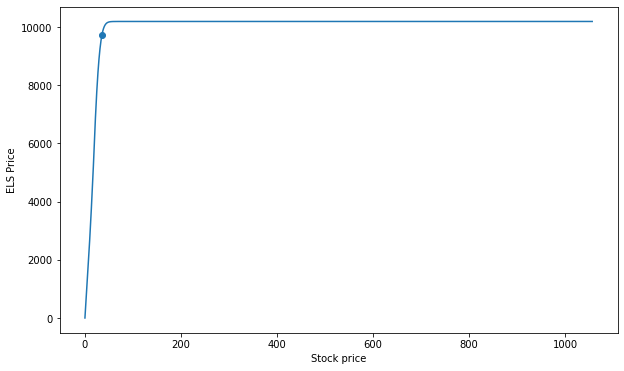

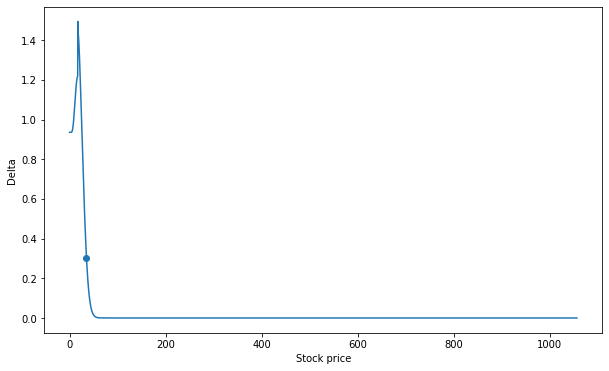

In [5]:
s = s*300
plt.figure(figsize=(10,6))
plt.plot(s, 10000*ELS_price[N,:])
plt.scatter(s[x0tag], 10000*ELS_price[N,x0tag])
plt.xlabel('Stock price')
plt.ylabel('ELS Price')
plt.show()

plt.figure(figsize=(10,6))
plt.plot(s[:-1], delta)
plt.scatter(s[x0tag], delta[x0tag])
plt.xlabel('Stock price')
plt.ylabel('Delta')
plt.show()

In [6]:
ELS_price[N,x0tag] * 10000

9717.279900596379

### 시뮬레이션 비교

In [7]:
import numpy as np
import pandas as pd
from IPython.display import display

'''---------------= INPUT DATA ----------------'''

num = 50000
num_asset = 1
step = 600
T = 3
dt = T / step #/num_time_step
len

q = 0.0223 #한국거래소 180일 배당수익률 
r = 0.03 #22/9월 20일  91 CD 금리
sigma = 0.2803
rate = 0.07

s_0 = 1

case_dict = {
    1 : s_0 * (1 + 0.5 * rate) / (1 + 0.5 * r),
    2 : s_0 * (1 + 1.0 * rate) / (1 + 1.0 * r),
    3 : s_0 * (1 + 1.5 * rate) / (1 + 1.5 * r),
    4 : s_0 * (1 + 2.0 * rate) / (1 + 2.0 * r),
    5 : s_0 * (1 + 2.5 * rate) / (1 + 2.5 * r),
    6 : s_0 * (1 + 3.0 * rate) / (1 + 3.0 * r),
    7 : s_0 * (1 + 3.0 * rate) / (1 + 3.0 * r),
    8 : s_0 / (1 + 3.0 * r)
}

case_date = np.linspace(0, step, len(case_dict)-1)[1:]

'''---------------- Equations and Simulation -----------------'''

path1 = np.ones((num, 1)) * s_0

z1 = np.random.normal(size=(step, num)).T

x1 = np.exp( (r - q - 0.5 * (sigma **2)) * dt + sigma * np.sqrt(dt) * z1)

for i in range(step):
    next_path = x1[:,i].reshape(num, 1) * path1[:, -1].reshape(num, 1)
    path1 = np.c_[path1, next_path]

path1_df = pd.DataFrame(data=path1, index=[x for x in range(num)], columns=[x for x in range(step+1)])

df = path1_df
display(df)


'''----------------------- Case by Case --------------------------'''

'''Case1 Check''' '''모두 6개월 시점에서 95 이상일때'''
case1_arr = ((path1_df[case_date[0]] >= 0.95) * 1)

'''Case2 Check''' '''모두 12개월 시점에서 90 이상일때'''
case2_arr = ((path1_df[case_date[1]] >= 0.90) * 1)
case2_arr = np.where((case2_arr - case1_arr) > 0, 1, 0)

'''Case3 Check''' '''모두 16개월 시점에서 85 이상일때'''
case3_arr = ((path1_df[case_date[2]] >= 0.85) * 1)
case3_arr = np.where((case3_arr - case2_arr - case1_arr) > 0, 1, 0)

'''Case4 Check''' '''모두 24개월 시점에서 80 이상일때'''
case4_arr = ((path1_df[case_date[3]] >= 0.80) * 1)
case4_arr = np.where(case4_arr - case3_arr - case2_arr - case1_arr > 0, 1 ,0)

'''Case5 Check''' '''모두 30개월 시점에서 75 이상일때'''
case5_arr = ((path1_df[case_date[4]] >= 0.75) * 1)
case5_arr = np.where(case5_arr - case4_arr - case3_arr - case2_arr - case1_arr > 0, 1 ,0)

'''Case6 Check 36개월 시점에서 75이상일때''' '''둘다 한번도 50 미만으로 하락한 적이 없고, 만기 평가 가격이 75미만일 경우'''
case6_arr = ((path1_df[case_date[5]] >= 0.75) * 1)
case6_arr = np.where(case6_arr - case5_arr - case4_arr - case3_arr - case2_arr - case1_arr > 0, 1, 0)

'''Case7 Check''' '''36개월 시점에서 75이상일때''' '''둘다 한번도 50 미만으로 하락한 적이 없고, 만기 평가 가격이 75미만일 경우'''
case7_arr = ( (((path1_df >= 0.50).prod(axis=1))) * ((((path1_df[case_date[5]] >= 0.75) * 1) - 1) **2))
case7_arr = np.where(case7_arr - case6_arr - case5_arr - case4_arr - case3_arr - case2_arr - case1_arr > 0, 1, 0)

'''Case8 Check, 조기상환 경우는 제외함''' '''둘다 한번이라도 50 미만으로 하락한 적이 있고, 만기 평가 가격이 한 종목 이라도 75 미만인 경우'''
case8_arr = ((((path1_df >= 0.50).prod(axis=1)) - 1 ) **2) * ((((path1_df[case_date[5]] >= 0.75) * 1) - 1) **2)
case8_arr = np.where(case8_arr - case7_arr - case6_arr - case5_arr - case4_arr - case3_arr - case2_arr - case1_arr  > 0, 1, 0)

case = case1_arr * 1 + case2_arr * 2 + case3_arr * 3 + case4_arr * 4 + case5_arr * 5 + case6_arr * 6 + case7_arr * 7 + case8_arr * 8
#case_check = case1_arr + case2_arr + case3_arr + case4_arr + case5_arr + case6_arr + case7_arr + case8_arr
'''--------------------- Values from case by case -------------------------'''

path1_df['case'] = case


y_arr = np.where(path1_df['case'] == 1, case_dict[1],\
        np.where(path1_df['case'] == 2, case_dict[2],\
        np.where(path1_df['case'] == 3, case_dict[3],\
        np.where(path1_df['case'] == 4, case_dict[4],\
        np.where(path1_df['case'] == 5, case_dict[5],\
        np.where(path1_df['case'] == 6, case_dict[6],\
        np.where(path1_df['case'] == 7, case_dict[7],\
        np.where(path1_df['case'] == 8, 0, 0))))))))

y_arr = y_arr + (((path1_df['case'] == 8) * path1_df[step])/s_0) * case_dict[8]

path1_df['Y'] = y_arr

#display(path1_df[['case', 'Y']])


'''------------------------- Price and Standard, and DF sorting -------------------------'''

value = path1_df['Y'].mean()
sample_std = np.sqrt(sum((path1_df['Y'] - value)**2)/(num-1))
mc_simul_error = sample_std/ np.sqrt(num)

prob_df = pd.DataFrame(data=path1_df.groupby('case').size().index, columns=['case']).set_index('case')
prob_df['count'] = path1_df.groupby('case').size()
prob_df['prob(%)'] = (path1_df.groupby('case').size() / num) * 100
prob = np.round(prob_df['prob(%)'].iloc[-1],2)

display(prob_df)

print(f'ELS price = {value}, standard error = {mc_simul_error}, Knock-in Prob = { prob }% ' )

,0,1,2,3,4,5,6,7,8,9,...,591,592,593,594,595,596,597,598,599,600
0,1.0,1.009454,1.032448,0.998924,1.015370,0.971877,0.983416,0.977949,0.967766,0.959212,...,0.593701,0.579454,0.590374,0.587894,0.574786,0.567920,0.558306,0.546648,0.545458,0.552210
1,1.0,1.010135,1.012549,1.014413,1.041634,1.028221,1.028264,1.012668,0.958927,0.946669,...,0.626886,0.644546,0.673606,0.679752,0.700134,0.690582,0.672254,0.672970,0.686363,0.694377
2,1.0,0.979349,0.972085,0.999012,1.014768,1.026457,1.032432,1.042823,1.057494,1.075845,...,0.764952,0.761770,0.725549,0.704966,0.714386,0.713728,0.713515,0.714988,0.735075,0.705080
3,1.0,1.011115,0.977907,0.988498,0.972424,0.938890,0.937747,0.964658,0.942998,0.943652,...,1.085864,1.079045,1.081409,1.061747,1.059507,1.071362,1.034720,1.028035,1.081630,1.098139
4,1.0,0.987137,0.994174,1.008806,1.009167,0.992273,0.954433,0.963946,0.961040,0.942443,...,0.569590,0.565487,0.591236,0.599990,0.608213,0.604699,0.597526,0.597467,0.584192,0.584797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1.0,1.012893,1.005315,1.011768,1.064346,1.094467,1.070480,1.034290,1.059493,1.047690,...,1.110235,1.119880,1.148443,1.124334,1.126784,1.117215,1.092172,1.089881,1.065877,1.074974
49996,1.0,1.001650,1.026710,1.016731,1.018974,0.988589,0.983925,0.973079,0.979114,0.961793,...,1.446150,1.463401,1.384267,1.366539,1.355999,1.329865,1.293187,1.307268,1.324539,1.265631
49997,1.0,0.993797,0.966995,0.966765,0.975871,0.968873,0.997199,1.040567,1.047874,1.069744,...,0.795605,0.810354,0.832716,0.817825,0.816042,0.818532,0.828630,0.858252,0.854578,0.859466
49998,1.0,1.003678,1.000991,0.981295,0.957586,0.940539,0.949426,0.925445,0.892153,0.890188,...,0.654772,0.669344,0.662590,0.666010,0.664297,0.672259,0.676767,0.673834,0.655096,0.644707


,count,prob(%)
case,,
1,28691,57.382
2,6989,13.978
3,3443,6.886
4,2109,4.218
5,1573,3.146
6,710,1.420
7,1268,2.536
8,5217,10.434


ELS price = 0.9716637110714081, standard error = 0.0008486547055404043, Knock-in Prob = 10.43% 
